### Will use three different unsupervised models on the song attribute data to create a recommendation system :)

In [1]:
import pandas as pd
import numpy as np
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans

#### Load dataset

In [2]:
songs_df = pd.read_csv("cleaned_data/songs_cleaned.csv")

#### Determine which attributes are numerical and which are categorical (will be used for standardizing)

In [3]:
# Get numerical columns
numerical_cols = songs_df.select_dtypes(include=['number']).columns.tolist()

In [4]:
categorical_cols = songs_df.select_dtypes(exclude=['number']).columns.tolist()

#### Using a ColumnTransformer, create a preprocessor that which standardize both the categorical and numerical attributes

In [5]:
X = songs_df.copy()  

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), categorical_cols),  
        ('num', MinMaxScaler(), numerical_cols)      
    ])

#### 1. KNN

In [34]:
knn = NearestNeighbors(n_neighbors=5, metric='euclidean')

In [35]:
# fit the knn
X_preprocessed = preprocessor.fit_transform(X)

In [36]:
knn.fit(X_preprocessed)

NearestNeighbors(metric='euclidean')

In [ ]:
def knn_recommender(key):

    if key not in songs_df["track_key"].values:
        return "not in database"
    
    song = songs_df.loc[songs_df["track_key"] == key]

    processed_song = preprocessor.transform(song)

    distances, indices = knn.kneighbors(processed_song)

    for j in range(len(distances[0])):
        print("Distance:", distances[0][j])
        # print("Indices:", indices[0][j])
        print("Song:", songs_df.iloc[indices[0][j]]["track_name"])

In [38]:
knn_recommender("higher love _ kygo")

Distance: 0.0
Song: higher love
Distance: 2.877900087486144
Song: stargazing
Distance: 2.886442875615471
Song: happy now
Distance: 2.9155523741535463
Song: think about you
Distance: 3.031763329882983
Song: not ok


### 2. K Means

In [6]:
# we do this in order to split properly later
X_preprocessed = preprocessor.fit_transform(songs_df)

In [7]:
X_train, X_temp = train_test_split(songs_df, test_size=0.2, random_state=42)

In [8]:
X_val, X_test = train_test_split(X_temp, test_size=0.5, random_state=42)

In [9]:
processed_X_train = preprocessor.transform(X_train)
processed_X_val = preprocessor.transform(X_val)
processed_X_test = preprocessor.transform(X_test)

### find the best k (the one with the highest silhouette score)

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# ranges of k to try
# this will be the number of groups within the songs
k_range = range(2, 1000, 5) 

# stores silhouette scores
# definition: quantifies how well a data point fits into its assigned cluster and how distinct it is from other clusters
silhouette_scores = []

for k in k_range:
    # 1. kmeans with k
    kmeans = KMeans(n_clusters=k, random_state=42)

    # 2. fit on training data
    kmeans.fit(processed_X_train)  
    
    
    # 3. predict clusters with validation data
    val_clusters = kmeans.predict(processed_X_val) 
    
    
    # 4. calculate silhouette score
    silhouette_avg = silhouette_score(processed_X_val, val_clusters)
    silhouette_scores.append(silhouette_avg)

    # print(f"Silhouette Score for k={k}: {silhouette_avg}")

# find the k with the highest silhouette score
best_k = k_range[silhouette_scores.index(max(silhouette_scores))]
print(f"The optimal number of clusters (k) is {best_k}.")

### might be easier to get k??

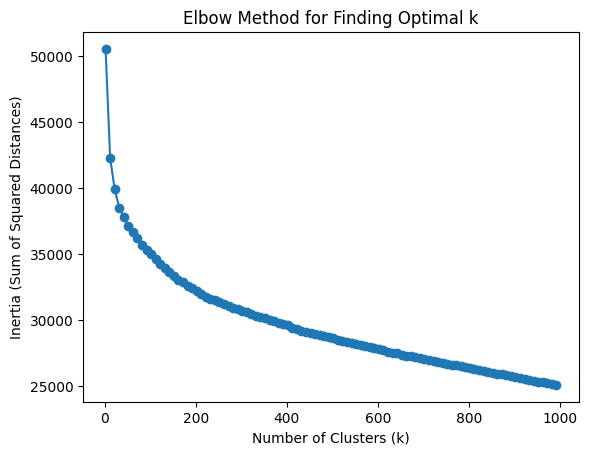

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Try fewer values of k first (e.g., from 2 to 100)
k_values = range(2, 1000, 10)  # Adjust this based on dataset size
inertia_scores = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(processed_X_train)
    inertia_scores.append(kmeans.inertia_)
    # print(k)

# Plot Inertia
plt.plot(k_values, inertia_scores, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (Sum of Squared Distances)')
plt.title('Elbow Method for Finding Optimal k')
plt.show()


In [16]:
kmeans = KMeans(n_clusters=70, random_state=42)

kmeans.fit(processed_X_train)

KMeans(n_clusters=70, random_state=42)

In [17]:
X_train['cluster'] = kmeans.fit_predict(processed_X_train)
X_val['cluster'] = kmeans.predict(processed_X_val)
X_test['cluster'] = kmeans.predict(processed_X_test)

In [18]:
def kmeans_recommender(key, n_recommendations):
    if key not in songs_df["track_key"].values:
        return "not in database"
    
    song = songs_df.loc[songs_df["track_key"] == key]

    processed_song = preprocessor.transform(song)

    predicted_cluster = kmeans.predict(processed_song)
    # print(predicted_cluster)

    similar_songs = X_train[X_train['cluster'] == predicted_cluster[0]]

    print(len(similar_songs))

    return similar_songs.head(n_recommendations)

In [19]:
kmeans_recommender("the pretender _ foo fighters", 4)

105


,track_name,track_artist,track_popularity,track_album_name,playlist_name,playlist_genre,playlist_subgenre,danceability,energy,key,...,instrumentalness,liveness,valence,tempo,duration_ms,track_key,track_album_release_year,track_album_release_month,track_album_release_day,cluster
4427,Drain You,Nirvana,58,Nevermind (Deluxe Edition),keg party jukebox,rock,permanent wave,0.325,0.929,11,...,0.000002,0.1840,0.198,133.358,223880,drain you _ nirvana,1991,9,26,69
4237,Last Nite,The Strokes,72,Is This It,"Muse Radio - (Uprising, Starlight, Supermassiv...",rock,permanent wave,0.624,0.910,0,...,0.000198,0.0789,0.767,104.042,193051,last nite _ the strokes,2001,7,30,69
4454,Notion,Kings of Leon,58,Only By The Night,keg party jukebox,rock,permanent wave,0.433,0.887,4,...,0.000029,0.1190,0.426,142.968,180840,notion _ kings of leon,2008,9,23,69
4462,Song 2,Blur,64,Blur: The Best Of,keg party jukebox,rock,permanent wave,0.658,0.709,8,...,0.004470,0.0657,0.855,129.699,121880,song 2 _ blur,2000,10,23,69


### 3. K Medoids